In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



from sklearn.model_selection import GridSearchCV


from skmisc.loess import loess

# Part 1

Span	CV	GCV
0.20	12.4159	2.1102
0.25	2.2415	1.4892
0.30	1.5030	1.1901
0.35	1.2592	1.1744
0.40	1.1904	1.1025
0.45	1.1568	1.0625
0.50	1.1243	1.0404
0.55	1.1797	1.1188
0.60	1.1795	1.1193
0.65	1.2509	1.1806
0.70	1.5536	1.5191
0.75	1.6362	1.6274
0.80	1.7645	1.7445
0.85	1.9761	1.9257
0.90	2.0351	1.9798

Best span: 0.50


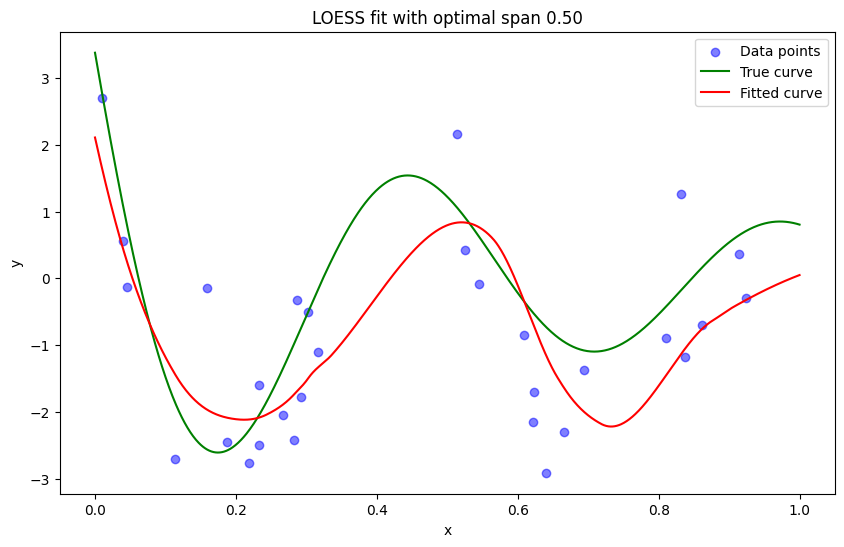

In [3]:
data = pd.read_csv('https://liangfgithub.github.io/Data/Coding3_Data.csv')

def get_diagonal(x, span):
    n, _ = x.shape

    fake_y = np.random.randn(n)
    loess_model = loess(x['x'].values, fake_y, span=span)
    
    loess_model.fit()

    out = loess_model.outputs.diagonal

    assert len(out) == n

    return out


def find_optimal_spans(data, span_values):
    y = data['y'].values
    n = data.shape[0]

    cv_values = []
    gcv_values = []

    for span in span_values:
        # Calculate diagonal elements of the hat matrix
        diag = get_diagonal(data, span)

        # Fit LOESS model
        loess_model = loess(data["x"].values, y, span=span)
        loess_model.fit()
        fitted = loess_model.outputs.fitted_values

        # Calculate residuals
        residuals = y - fitted

        # Calculate CV and GCV
        cv = np.mean((residuals / (1 - diag))**2)
        gcv = np.mean((residuals / (1 - np.mean(diag)))**2)

        cv_values.append(cv)
        gcv_values.append(gcv)

    # Find optimal spans
    best_cv_span = span_values[np.argmin(cv_values)]
    best_gcv_span = span_values[np.argmin(gcv_values)]

    return {
        'span_values': span_values,
        'cv_values': cv_values,
        'gcv_values': gcv_values,
        'best_cv_span': best_cv_span,
        'best_gcv_span': best_gcv_span
    }

span_values = np.linspace(0.2, 0.9, 15)
results = find_optimal_spans(data, span_values)


# Print CV and GCV values
print("Span\tCV\tGCV")
for span, cv, gcv in zip(results['span_values'], results['cv_values'], results['gcv_values']):
    print(f"{span:.2f}\t{cv:.4f}\t{gcv:.4f}")

# This comes from the homework prompt
assert(results['best_cv_span'] == results['best_gcv_span'], "Dataset expected to have the same optimal span for CV and GCV")

# Determine the best span
best_span = results['best_cv_span'] 
print(f"\nBest span: {best_span:.2f}")

# Fit LOESS model with the optimal span
x = data['x'].values
y = data['y'].values
loess_model = loess(x, y, span=best_span)
loess_model.fit()

# Generate points for smooth curves
x_smooth = np.linspace(0, 1, 1000)

# True curve
def true_curve(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

y_true = true_curve(x_smooth)

# Fitted curve (only within the range of original data)
x_min, x_max = x.min(), x.max()
x_fit = np.linspace(x_min, x_max, 1000)
loess_smooth = loess(x, y, span=best_span)
loess_smooth.fit()
y_fitted = loess_smooth.predict(x_fit).values

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.5, label='Data points')
plt.plot(x_smooth, y_true, color='green', label='True curve')
plt.plot(x_smooth, y_fitted, color='red', label='Fitted curve')
plt.legend()
plt.title(f'LOESS fit with optimal span {best_span:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Part 2

In [27]:
import scipy
data = pd.read_csv('https://liangfgithub.github.io/F22/Coding3_dataH.csv', header=None)
print(data.shape)
assert data.shape == (506, 241), "Data shape is incorrect"


def ridgeless(train, test, eps = 1e-10):
    assert train.shape[1] == test.shape[1], "Train and test data must have the same number of features"
    # Conver pandas dataframes to numpy arrays
    train = train.to_numpy() 
    test = test.to_numpy()
       # Separate response and features
    Y_train = train[:, 0]
    X_train = train[:, 1:]
    Y_test = test[:, 0]
    X_test = test[:, 1:]
    
    # Center the training data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_centered = X_train - X_train_mean
    
    # Center the test data using training mean
    X_test_centered = X_test - X_train_mean
    
    # Estimate intercept as mean of Y_train
    b0 = np.mean(Y_train)

    U, D, Vt = scipy.linalg.svd(X_train_centered, full_matrices=False)
    
    # Identify number of singular values greater than eps
    k = np.sum(D > eps)

    V_trunc = Vt[:k, :].T
    
   # Update feature matrix F
    F = X_train_centered @ V_trunc  # Shape: (n_train, k)

     # Compute (F^T F), which is diagonal
    FTF = np.diag(np.sum(F * F, axis=0))  # Shape: (k, k)
    
    # Compute F^T Y_train
    FTY = F.T @ Y_train  # Shape: (k,)
    
    # Compute alpha_hat = (F^T F)^{-1} F^T Y_train
    # Since FTF is diagonal, inverse is reciprocal of diagonal elements
    inv_FTF = np.diag(1 / np.diag(FTF))
    alpha_hat = inv_FTF @ FTY  # Shape: (k,)
    
    # Alternatively, since FTF is diagonal, alpha_hat can be computed as:
    # alpha_hat = FTY / np.diag(FTF)
    # Uncomment the line below to use this alternative computation
    # alpha_hat = FTY / np.diag(FTF)
    
    # Compute predictions on training data
    Yhat_train = b0 + F @ alpha_hat  # Shape: (n_train,)
    
    # Transform X_test
    F_test = X_test_centered @ V_trunc  # Shape: (n_test, k)
    
    # Compute predictions on test data
    Yhat_test = b0 + F_test @ alpha_hat  # Shape: (n_test,)
    
    # Calculate Mean Squared Errors
    train_mse = np.mean((Yhat_train - Y_train) ** 2)
    test_mse = np.mean((Yhat_test - Y_test) ** 2)
    
    return train_mse, test_mse

    

(506, 241)


(126, 241) (380, 241)
Iteration 1/30 completed.
(126, 241) (380, 241)
Iteration 2/30 completed.
(126, 241) (380, 241)
Iteration 3/30 completed.
(126, 241) (380, 241)
Iteration 4/30 completed.
(126, 241) (380, 241)
Iteration 5/30 completed.
(126, 241) (380, 241)
Iteration 6/30 completed.
(126, 241) (380, 241)
Iteration 7/30 completed.
(126, 241) (380, 241)
Iteration 8/30 completed.
(126, 241) (380, 241)
Iteration 9/30 completed.
(126, 241) (380, 241)
Iteration 10/30 completed.
(126, 241) (380, 241)
Iteration 11/30 completed.
(126, 241) (380, 241)
Iteration 12/30 completed.
(126, 241) (380, 241)
Iteration 13/30 completed.
(126, 241) (380, 241)
Iteration 14/30 completed.
(126, 241) (380, 241)
Iteration 15/30 completed.
(126, 241) (380, 241)
Iteration 16/30 completed.
(126, 241) (380, 241)
Iteration 17/30 completed.
(126, 241) (380, 241)
Iteration 18/30 completed.
(126, 241) (380, 241)
Iteration 19/30 completed.
(126, 241) (380, 241)
Iteration 20/30 completed.
(126, 241) (380, 241)
Iterati

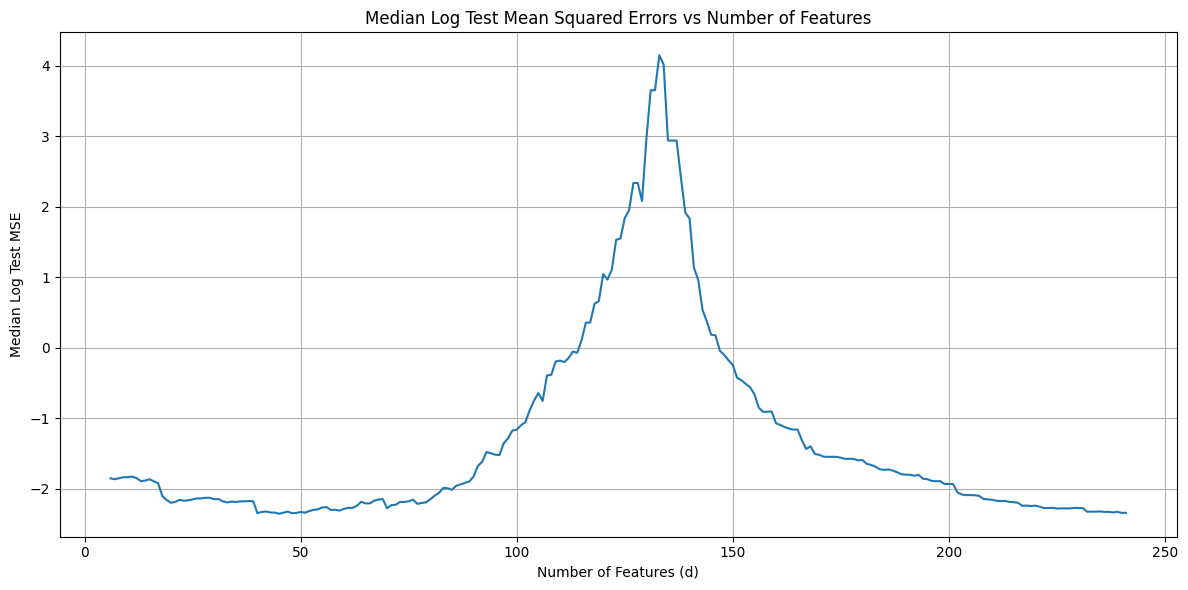

In [29]:
# Part 2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def simulation_study(data, T=30, d_min=6, d_max=241, eps=1e-10, random_state=None):
    """
    Performs a simulation study for Ridgeless Least Squares.
    
    Parameters:
    - data: pandas DataFrame, first column is Y, remaining columns are features X
    - T: int, number of iterations (default=30)
    - d_min: int, minimum number of columns to use (including Y) (default=6)
    - d_max: int, maximum number of columns to use (including Y) (default=241)
    - eps: float, threshold to exclude small singular values (default=1e-10)
    - random_state: int or None, seed for reproducibility
    
    Returns:
    - log_test_errors: numpy array of shape (T, d_max - d_min + 1)
    """
    
    # Initialize the matrix to store log test errors
    num_d = d_max - d_min + 1  # 241 - 6 +1 = 236
    log_test_errors = np.zeros((T, num_d))
    
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    for t in range(T):
        # Split the data into training (25%) and test (75%)
        train_df, test_df = train_test_split(data, test_size=0.75, random_state=None, shuffle=True)

        print(train_df.shape, test_df.shape)
        
        # Iterate over d from d_min to d_max
        for idx, d in enumerate(range(d_min, d_max + 1)):
            train_subset = train_df.iloc[:, :d]
            test_subset = test_df.iloc[:,:d]
            
            # Compute log test error using ridgeless function
            _, test_mse = ridgeless(train_subset, test_subset, eps=eps)
            log_test_error = np.log(test_mse + 1e-12)  # Add small constant to avoid log(0)
            
            # Store the log test error
            log_test_errors[t, idx] = log_test_error
        
        # Optional: Print progress
        print(f"Iteration {t+1}/{T} completed.")
    
    return log_test_errors

# Perform the simulation study
T = 30
d_min = 6
d_max = 241
eps = 1e-10
random_state = 42  # TODO: Switch this to use the UIN

log_test_errors = simulation_study(data, T=T, d_min=d_min, d_max=d_max, eps=eps, random_state=random_state)

# Convert log_test_errors to a Pandas DataFrame for easier handling
d_values = range(d_min, d_max + 1)  # 6 to 241
log_test_errors_df = pd.DataFrame(log_test_errors, columns=[f'd={d}' for d in d_values])

# Compute the median log test error across iterations for each d
median_log_test_errors = log_test_errors_df.median(axis=0)

# Plot the median log test errors vs d
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(d_min, d_max + 1), y=median_log_test_errors.values)
plt.xlabel('Number of Features (d)')
plt.ylabel('Median Log Test MSE')
plt.title('Median Log Test Mean Squared Errors vs Number of Features')
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 3

In [55]:
# Provided reference function from Professor
# converted from R's ns()
from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)


    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis
    

In [58]:
import scipy.linalg

# Part 1

data_3_df = pd.read_csv("https://liangfgithub.github.io/Data/Sales_Transactions_Dataset_Weekly.csv")
# Get all columns with 'W' as the first character
week_columns = [col for col in data_3_df.columns if col[0] == 'W']

# Create a new dataframe with only the week columns
data_3_weeks = data_3_df[week_columns].values

# Center each row by subtracting the mean
data_3_weeks_centered = data_3_weeks - data_3_weeks.mean(axis=1, keepdims=True)

assert data_3_weeks_centered.mean(axis=1).sum() < 1e-10, "Centered data should have mean close to zero"
assert data_3_weeks_centered.shape == (811, 52), "Centered data shape is incorrect"

F_matrix = ns(x=np.arange(1,53), df=9, include_intercept=False)  
assert F_matrix.shape == (52,9)

# Remove the column means
F_matrix_centered = F_matrix - F_matrix.mean(axis=0, keepdims=True)

B_t = scipy.linalg.inv(F_matrix_centered.T @ F_matrix_centered) @ F_matrix_centered.T @ data_3_weeks_centered.T

assert B_t.shape == (9, 811), "B_t shape is incorrect"







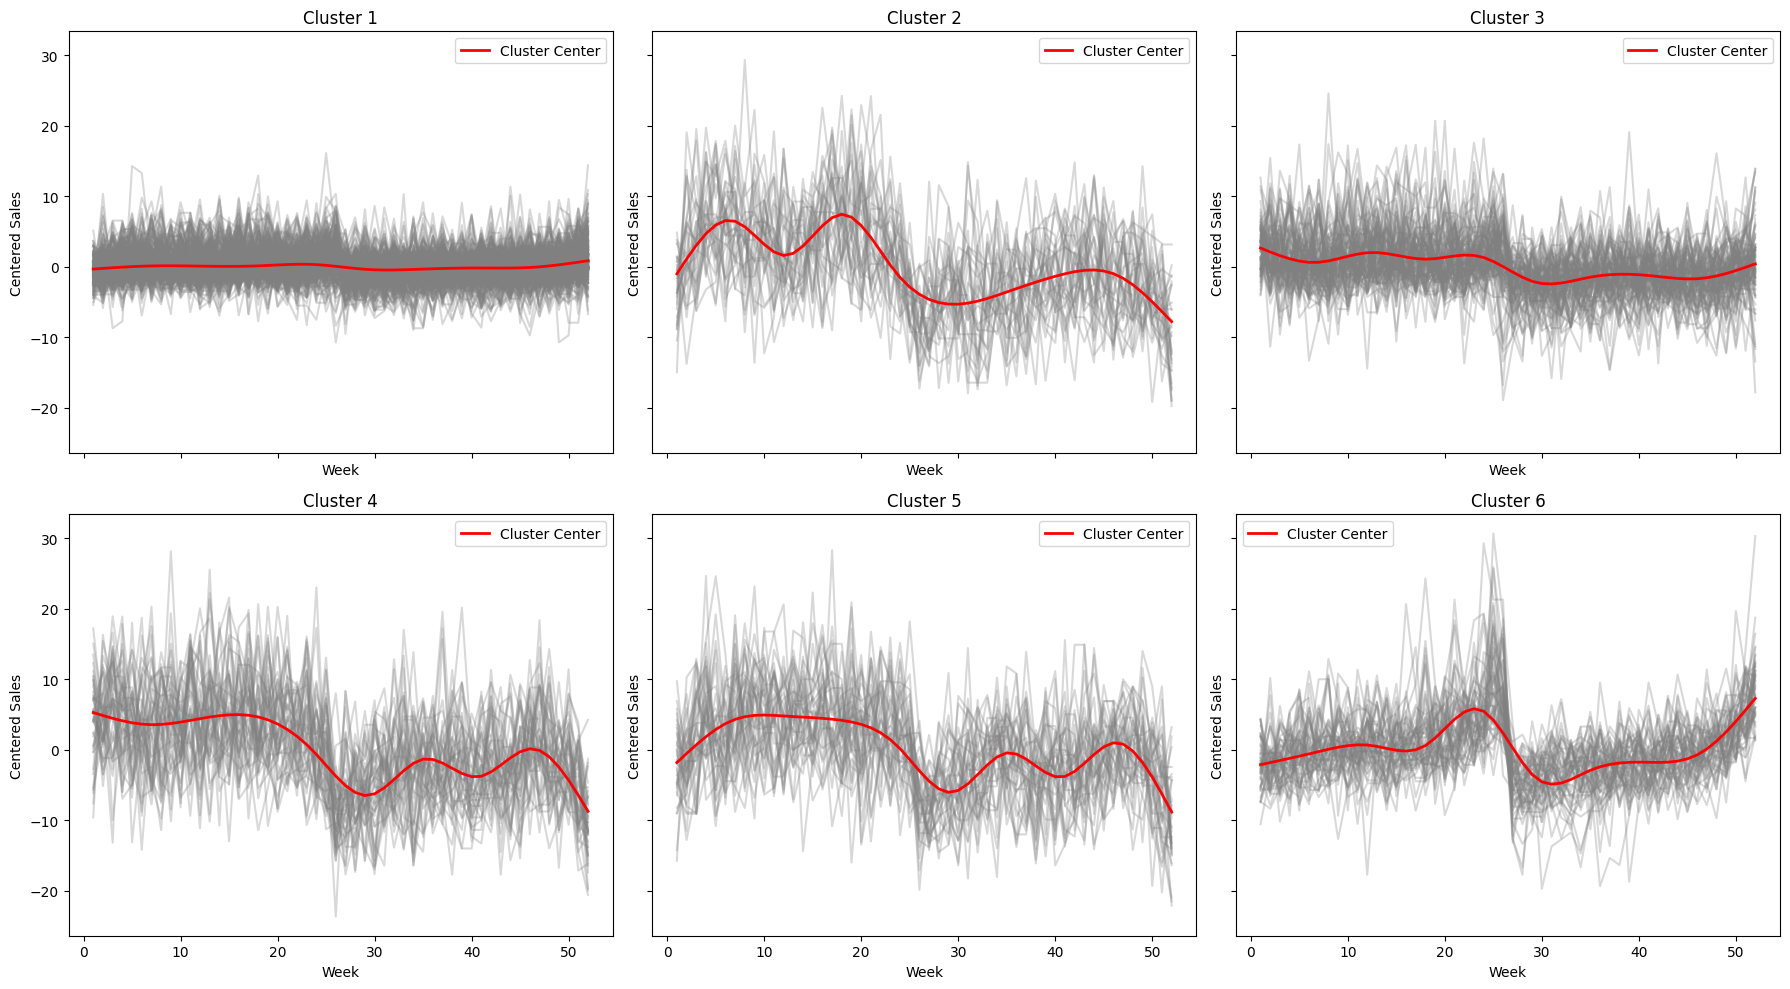

In [60]:
# Part 2
from sklearn.cluster import KMeans

kmeans_B = KMeans(n_clusters=6, n_init=25, random_state=123)
kmeans_B.fit(B_t.T)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

clusters_B = kmeans_B.labels_  # Array of shape (811,)


# Get cluster centers in B space (6 x 9)
centers_B = kmeans_B.cluster_centers_  # Shape: (6, 9)

# Reconstruct the cluster center time series using F_matrix_centered
# F_matrix_centered: (52, 9), centers_B: (6, 9)
# To get (6, 52), perform dot product
time_series_centers_B = centers_B @ F_matrix_centered.T

# Week indices for plotting
weeks = np.arange(1, 53)

for i in range(6):
    ax = axes[i]
    
    # Get indices of products in cluster i
    cluster_indices = np.where(clusters_B == i)[0]
    
    # Plot all time series in grey
    for idx in cluster_indices:
        ax.plot(weeks, data_3_weeks_centered[idx, :], color='grey', alpha=0.3)
    
    # Overlay the cluster center in red
    ax.plot(weeks, time_series_centers_B[i, :], color='red', linewidth=2, label='Cluster Center')
    
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Week')
    ax.set_ylabel('Centered Sales')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()



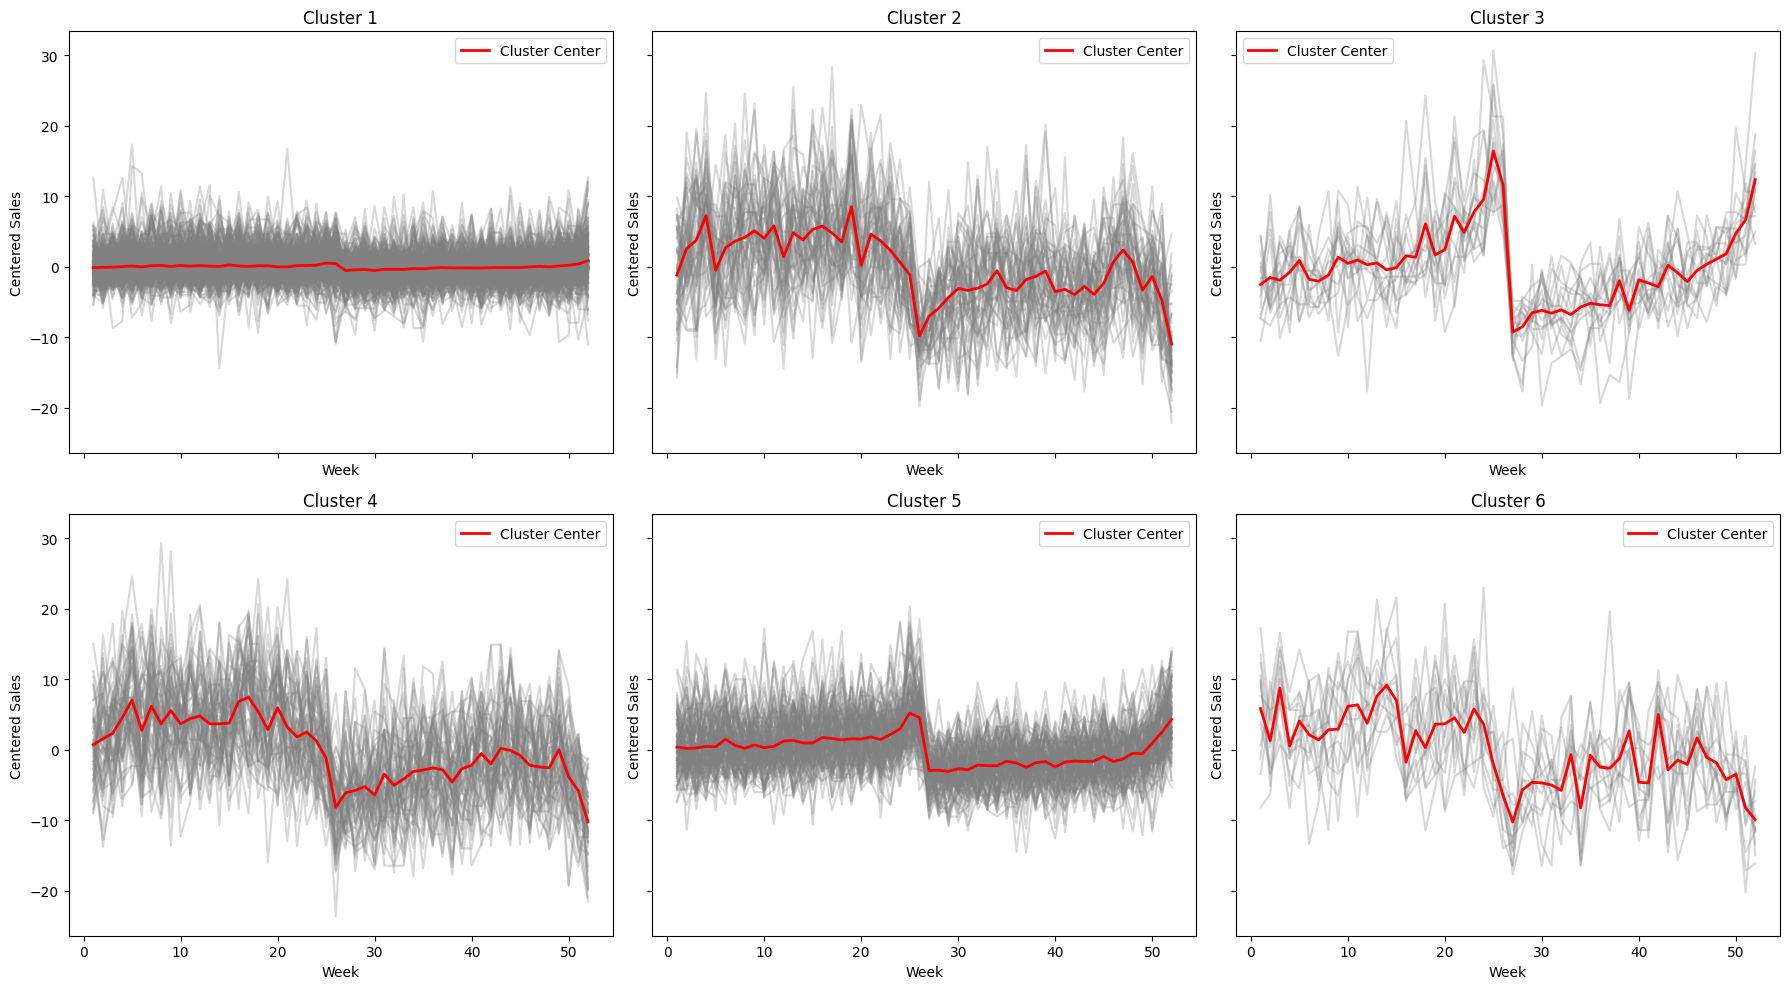

In [66]:
# Part 3
kmeans_X = KMeans(n_clusters=6, n_init=25, random_state=123)
kmeans_X.fit(data_3_weeks_centered)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

clusters_X = kmeans_X.labels_  # Array of shape (811,)


# Get cluster centers in B space (6 x 9)
centers_X = kmeans_X.cluster_centers_  # Shape: (6, 9)




# Week indices for plotting
weeks = np.arange(1, 53)

for i in range(6):
    ax = axes[i]
    
    # Get indices of products in cluster i
    cluster_indices = np.where(clusters_X == i)[0]
    
    # Plot all time series in grey
    for idx in cluster_indices:
        ax.plot(weeks, data_3_weeks_centered[idx, :], color='grey', alpha=0.3)
    
    # Overlay the cluster center in red
    ax.plot(weeks, centers_X[i, :], color='red', linewidth=2, label='Cluster Center')
    
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Week')
    ax.set_ylabel('Centered Sales')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()